                           spot_price
datetime_utc                         
2015-12-31 23:00:00+00:00       16.39
2016-01-01 00:00:00+00:00       16.04
2016-01-01 01:00:00+00:00       15.74
2016-01-01 02:00:00+00:00       15.57
2016-01-01 03:00:00+00:00       15.47
Training data shape: (23500,)
Test data shape: (168,)
[flaml.automl.logger: 10-27 12:37:14] {1728} INFO - task = ts_forecast
[flaml.automl.logger: 10-27 12:37:14] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 10-27 12:37:14] {1838} INFO - Minimizing error metric: mae
[flaml.automl.logger: 10-27 12:37:14] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'prophet', 'arima', 'sarimax', 'holt-winters']
[flaml.automl.logger: 10-27 12:37:14] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-27 12:37:32] {2393} INFO - Estimated sufficient time budget=184518s. Estimated necessary time budget=185s.
[flaml.automl.logger: 10-27 12:37:32] {

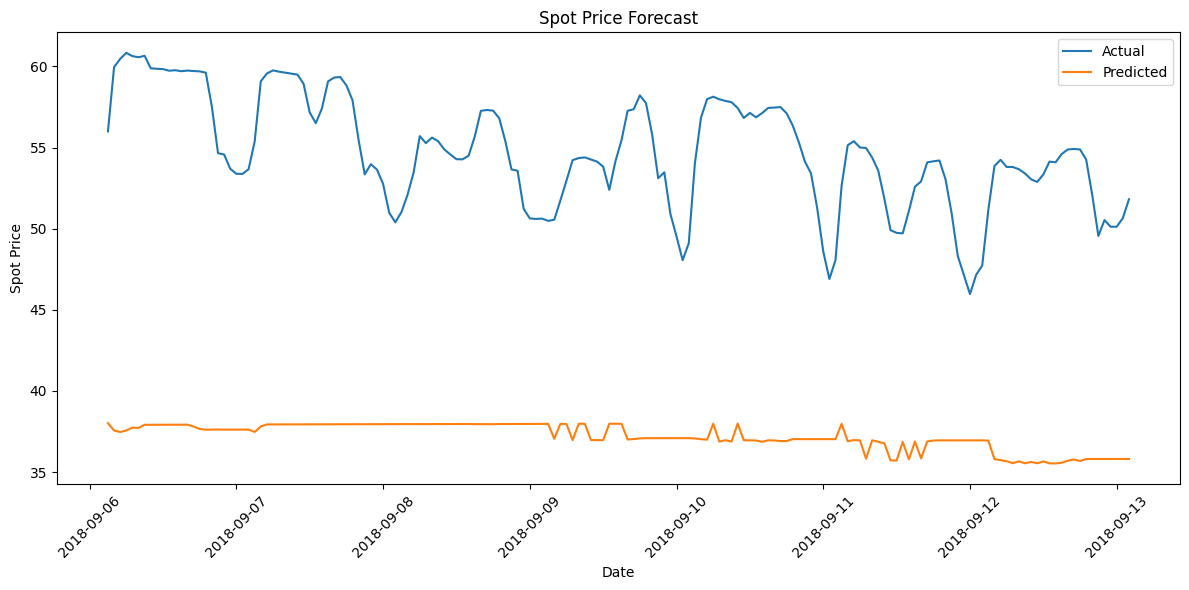

In [29]:
# Cell 1: Import libraries and load data
import pandas as pd
import numpy as np
from flaml import AutoML
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import plotly

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Load the data
df = pd.read_csv('Datasets/data_NO2.csv', sep=';', parse_dates=['datetime_utc'])

# Keep only datetime and spot_price columns
df = df[['datetime_utc', 'spot_price']]

# Set datetime_utc as index
df.set_index('datetime_utc', inplace=True)

# Sort the index to ensure chronological order
df.sort_index(inplace=True)

# Resample to hourly frequency
df = df.resample('h').mean()

# Fill any missing values (if any) with forward fill
df = df.ffill()

print(df.head())

# Cell 2: Prepare data for forecasting
# Define the forecast horizon (24*7 = 168 hours)
forecast_horizon = 168

# Split the data into train and test sets
train_size = len(df) - forecast_horizon
train_df = df[:train_size]
test_df = df[train_size:]

# Prepare X and y for FLAML
X_train = train_df.index.values
y_train = train_df['spot_price'].values

X_test = test_df.index.values

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# Cell 3: Set up and run FLAML AutoML
automl = AutoML()

# Set up the AutoML run
automl_settings = {
    "time_budget": 185,  # in seconds
    "metric": 'mape',
    "task": 'ts_forecast',
    "log_file_name": "flaml_automl.log",
    "eval_method": "holdout",
    "period": forecast_horizon,
    "estimator_list": ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'prophet', 'arima', 'sarimax', 'holt-winters'],
}

# Fit the AutoML model
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

# Print the best model and its hyperparameters
print("Best model:", automl.best_estimator)
print("Best hyperparameters:", automl.best_config)

# Cell 4: Make predictions and evaluate
# Make predictions
y_pred = automl.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(test_df['spot_price'].values, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

# Calculate MAPE
mape = mean_absolute_percentage_error(test_df['spot_price'].values, y_pred)
print(f"Mean Absolute Percentage Error: {mape:.2f}")

# Cell 5: Visualize results
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df['spot_price'].values, label='Actual')
plt.plot(test_df.index, y_pred, label='Predicted')
plt.title('Spot Price Forecast')
plt.xlabel('Date')
plt.ylabel('Spot Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()